### Overview

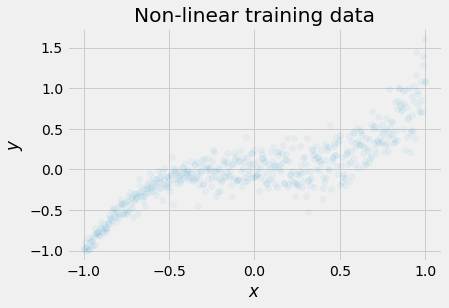

In [20]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

tfd = tfp.distributions
tfpl = tfp.layers

# Create non-linear data
n_samples = int(5e2)
x_train = np.linspace(-1, 1, n_samples)[:, np.newaxis]
y_train = x_train**3 + 0.1*(1.5 + x_train)*np.random.randn(n_samples)[:, np.newaxis]

# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=0.05)
plt.title('Non-linear training data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [21]:
# Prior - diagonal MVN ~ N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    prior_model = tf.keras.Sequential([
        
        tfpl.DistributionLambda(
            # Note: Our prior is a non-trianable distribution
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    
    return prior_model

In [22]:
# Posterior
def posterior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    posterior_model = tf.keras.Sequential([
        
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    
    return posterior_model

In [23]:
# Define the model
def get_full_model(x_train_shape):
    
    model = tf.keras.Sequential([

        # Epistemic uncertainty
        tfpl.DenseVariational(units=8,
                              input_shape=(1,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_use_exact=False,
                              kl_weight=1/x_train_shape),

        # Aleatoric uncertainty
        tfpl.IndependentNormal(1)
    ])

    def neg_loglik(y_true, y_pred):
        return -y_pred.log_prob(y_true)

    model.compile(loss=neg_loglik, optimizer='rmsprop')
    
    return model

Epoch 1/1000
16/16 [==============================] - 1s 716us/step - loss: 2.6456
Epoch 2/1000
16/16 [==============================] - 0s 700us/step - loss: 33.4864
Epoch 3/1000
16/16 [==============================] - 0s 736us/step - loss: 9.1137
Epoch 4/1000
16/16 [==============================] - 0s 675us/step - loss: 1.9901
Epoch 5/1000
16/16 [==============================] - 0s 674us/step - loss: 27.2351
Epoch 6/1000
16/16 [==============================] - 0s 763us/step - loss: 3.9356
Epoch 7/1000
16/16 [==============================] - 0s 617us/step - loss: 9.6417
Epoch 8/1000
16/16 [==============================] - 0s 525us/step - loss: 3.9412
Epoch 9/1000
16/16 [==============================] - 0s 648us/step - loss: 3.9997
Epoch 10/1000
16/16 [==============================] - 0s 597us/step - loss: 11.5220
Epoch 11/1000
16/16 [==============================] - 0s 615us/step - loss: 8.5831
Epoch 12/1000
16/16 [==============================] - 0s 600us/step - loss: 3.742

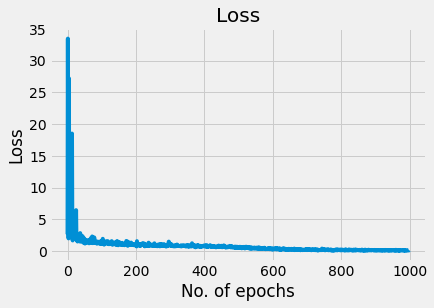

In [24]:
# Get the model
model_full = get_full_model(n_samples)

# Fit
history = model_full.fit(x_train, y_train, epochs=1000, verbose=True)

# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.show()

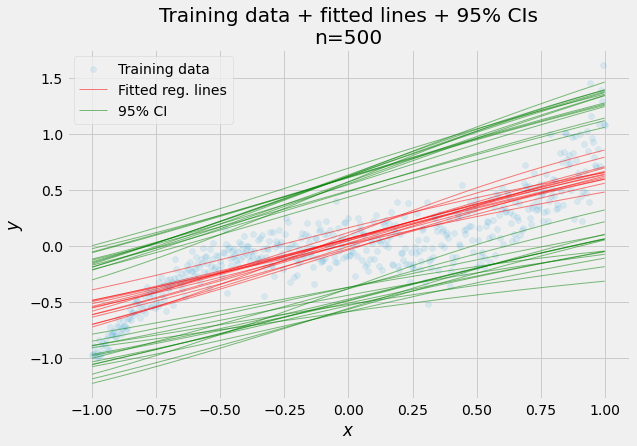

In [25]:

# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(9, 6))

#------------------------------

plt.scatter(x_train, y_train, alpha=.1, label='Training data')
for _ in range(N_ITERS):
    
    # Compute conf ints
    y_sample = model_full(x_train).sample()
    y_hat = model_full(x_train).mean()
    y_sd = model_full(x_train).stddev()
    y_hat_lower = y_hat - 2 * y_sd
    y_hat_upper = y_hat + 2 * y_sd
    

    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1, label='Fitted reg. lines')
        plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1, label='95% CI')
        plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1)    
        plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1)
        plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

#------------------------------

plt.title(f'Training data + fitted lines + 95% CIs\nn={n_samples}')
plt.show()

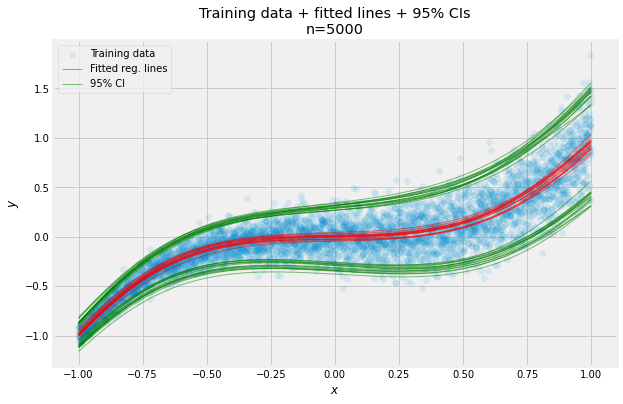

In [8]:

# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(9, 6))

#------------------------------

plt.scatter(x_train, y_train, alpha=.1, label='Training data')
for _ in range(N_ITERS):
    
    # Compute conf ints
    y_sample = model_full(x_train).sample()
    y_hat = model_full(x_train).mean()
    y_sd = model_full(x_train).stddev()
    y_hat_lower = y_hat - 2 * y_sd
    y_hat_upper = y_hat + 2 * y_sd
    

    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1, label='Fitted reg. lines')
        plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1, label='95% CI')
        plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1)    
        plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1)
        plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

#------------------------------

plt.title(f'Training data + fitted lines + 95% CIs\nn={n_samples}')
plt.show()

In [26]:
x_train.shape

(500, 1)

In [17]:
x_test = np.arange(-2, 2, 0.001).reshape(-1, 1)

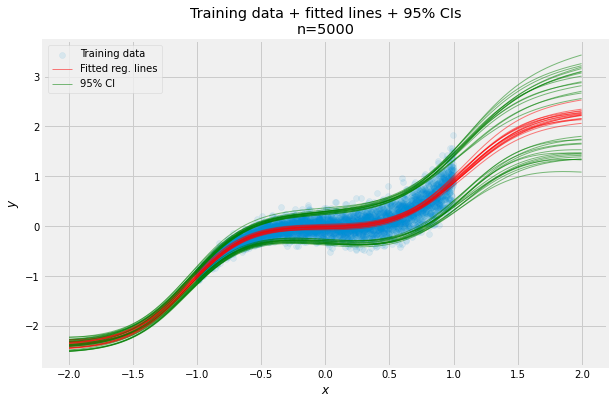

In [19]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(9, 6))

#------------------------------

plt.scatter(x_train, y_train, alpha=.1, label='Training data')
for _ in range(N_ITERS):
    
    # Compute conf ints
    y_sample = model_full(x_test).sample()
    y_hat = model_full(x_test).mean()
    y_sd = model_full(x_test).stddev()
    y_hat_lower = y_hat - 2 * y_sd
    y_hat_upper = y_hat + 2 * y_sd
    

    if _ == 0:
        plt.plot(x_test, y_hat, color='red', alpha=.5, lw=1, label='Fitted reg. lines')
        plt.plot(x_test, y_hat_lower, c='g', alpha=.5, lw=1, label='95% CI')
        plt.plot(x_test, y_hat_upper, c='g', alpha=.5, lw=1)
    else:
        plt.plot(x_test, y_hat, color='red', alpha=.5, lw=1)    
        plt.plot(x_test, y_hat_lower, c='g', alpha=.5, lw=1)
        plt.plot(x_test, y_hat_upper, c='g', alpha=.5, lw=1)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

#------------------------------

plt.title(f'Training data + fitted lines + 95% CIs\nn={n_samples}')
plt.show()

In [ ]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(9, 6))

#------------------------------

plt.scatter(x_train, y_train, alpha=.1, label='Training data')
for _ in range(N_ITERS):
    
    # Compute conf ints
    y_sample = model_full(x_test).sample()
    y_hat = model_full(x_test).mean()
    y_sd = model_full(x_test).stddev()
    y_hat_lower = y_hat - 2 * y_sd
    y_hat_upper = y_hat + 2 * y_sd
    

    if _ == 0:
        plt.plot(x_test, y_hat, color='red', alpha=.5, lw=1, label='Fitted reg. lines')
        plt.plot(x_test, y_hat_lower, c='g', alpha=.5, lw=1, label='95% CI')
        plt.plot(x_test, y_hat_upper, c='g', alpha=.5, lw=1)
    else:
        plt.plot(x_test, y_hat, color='red', alpha=.5, lw=1)    
        plt.plot(x_test, y_hat_lower, c='g', alpha=.5, lw=1)
        plt.plot(x_test, y_hat_upper, c='g', alpha=.5, lw=1)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

#------------------------------

plt.title(f'Training data + fitted lines + 95% CIs\nn={n_samples}')
plt.show()

In [30]:
model_full(x_test).sample().shape

TensorShape([4000, 1])

In [29]:
model_full.predict(x_test).shape

125/125 [==============================] - 0s 533us/step


(4000, 1)

In [31]:
preds_via_sample_list = []
preds_via_predict_list = []
for x in range(0, 100):
    preds_via_sample_list.append(model_full(x_test).sample())
    preds_via_predict_list.append(model_full.predict(x_test))

125/125 [==============================] - 0s 817us/step


<tf.Tensor: shape=(4000, 1), dtype=float32, numpy=
array([[-1.1573119 ],
       [-1.1487845 ],
       [-1.6016183 ],
       ...,
       [ 0.73470104],
       [ 1.5818609 ],
       [ 0.53390545]], dtype=float32)>

In [48]:
preds_via_sample = np.array(preds_via_sample_list).reshape(4000, 100)
preds_via_predict = np.array(preds_via_predict_list).reshape(4000, 100)

In [54]:

preds_via_sample.mean(axis=1).shape

(4000,)

In [55]:
x_test.shape

(4000, 1)

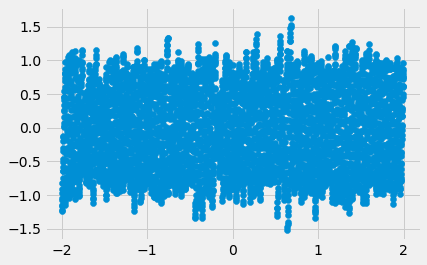

In [66]:
plt.scatter(x_test, preds_via_sample.mean(axis=1))

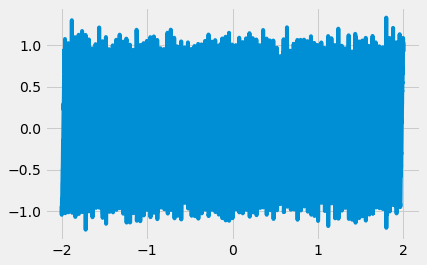

In [57]:
plt.plot(x_test, preds_via_predict.mean(axis=1))

In [62]:
x_test.shape



(4000, 1)

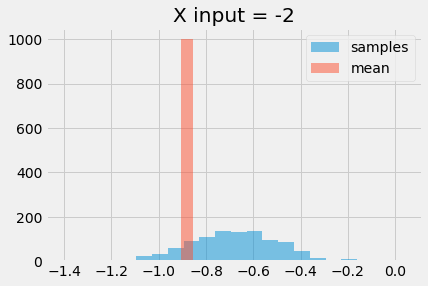

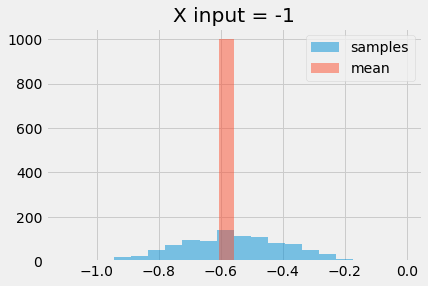

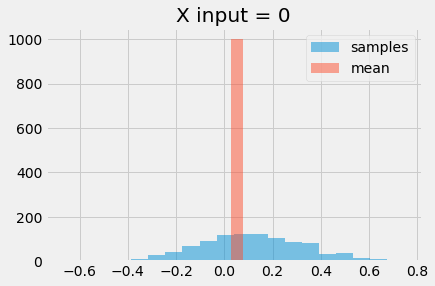

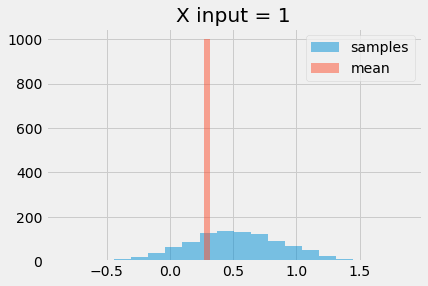

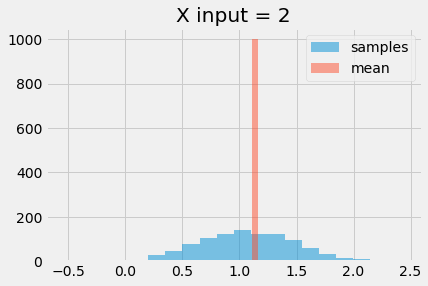

In [102]:
# res = model_full.predict((np.zeros(100) + 1).reshape(-1, 1))
iters = 1000
inputs = [-2, -1, 0, 1, 2]
for inp in inputs:
    input_arr = (np.zeros(1000) + inp).reshape(-1, 1)

    y = model_full.predict(input_arr)

    # y is a distribution object
    # y has methods, .sample, .mean, .stddev, .entropy

    y_samp = .sample().numpy()
    y_mean = model_full(input_arr).mean().numpy()
    y_stddev = model_full(input_arr).stddev().numpy()

    plt.hist(y_samp, alpha=0.5, bins=20, label='samples')
    plt.hist(y_mean, alpha=0.5, bins=20, label='mean')
    # plt.hist(y_stddev, alpha=0.5, bins=20, label='std')
    plt.legend()

    plt.title(f'X input = {inp}')
    plt.show()


(array([  3.,  21.,  57., 148., 202., 250., 189.,  89.,  36.,   5.]),
 array([-1.5801669 , -1.4611629 , -1.3421588 , -1.2231548 , -1.1041508 ,
        -0.9851467 , -0.86614263, -0.7471386 , -0.62813455, -0.50913054,
        -0.39012647], dtype=float32),
 <BarContainer object of 10 artists>)

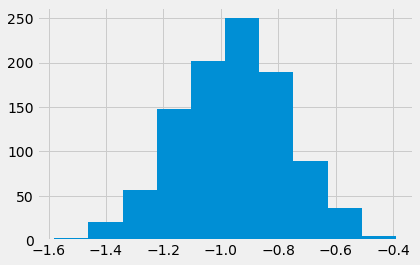

In [95]:
plt.hist(y_samp.numpy())

In [104]:
x_test

array([[-2.   ],
       [-1.999],
       [-1.998],
       ...,
       [ 1.997],
       [ 1.998],
       [ 1.999]])

In [105]:
model_full.predict(x_test)

125/125 [==============================] - 0s 969us/step


array([[-1.0847   ],
       [-1.3802181],
       [-1.6127383],
       ...,
       [ 1.0108522],
       [ 1.2998608],
       [ 1.330195 ]], dtype=float32)

In [106]:
model_full.predict(x_test)

125/125 [==============================] - 0s 971us/step


array([[-1.1046474 ],
       [-0.79672176],
       [-1.2521868 ],
       ...,
       [ 0.8492678 ],
       [ 1.3486129 ],
       [ 0.771096  ]], dtype=float32)

In [108]:
model_full(x_test).mean()

<tf.Tensor: shape=(4000, 1), dtype=float32, numpy=
array([[-1.0927174],
       [-1.0923675],
       [-1.0920173],
       ...,
       [ 1.0245303],
       [ 1.0249054],
       [ 1.0252802]], dtype=float32)>

In [109]:
model_full(x_test).stddev()

<tf.Tensor: shape=(4000, 1), dtype=float32, numpy=
array([[0.20418634],
       [0.20420505],
       [0.2042238 ],
       ...,
       [0.34052283],
       [0.3405503 ],
       [0.34057778]], dtype=float32)>

In [107]:
model_full(x_test)

<tfp.distributions.Independent 'sequential_3_independent_normal_3_IndependentNormal_Independentsequential_3_independent_normal_3_IndependentNormal_Normal' batch_shape=[4000] event_shape=[1] dtype=float32>

In [ ]:
# To store:
# mean std weight (of each gaussian)

# Just aleatoric uncertainty (2 gaussians)
# Single prediction: [
 # guassian 1: [mu=1, std=1.5, weight=0.5],
# gaussian 2:  [mu=2.5, std=1, weight=0.5]]        

# Epistemic
# Single Prediction:
#   - [[mu=1, std=1.5, weight=0.5], [mu=2.5, std=1, weight=0.5]]        
#   - [[mu=-1, std=3, weight=0.5], [mu=2.5, std=1, weight=0.5]]   
#   - [[mu=2, std=1.5, weight=0.5], [mu=2.5, std=1, weight=0.5]]          